# Intro to Graph Convolutional Network

In [ ]:
import numpy as np

In [ ]:
A_m = np.matrix([
    [0, 1, 1, 1],
    [0, 0, 1, 1],
    [1, 0, 0, 0],
    [0, 0, 1, 0]
], dtype=np.float32)
A_m

matrix([[0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.]], dtype=float32)

In [ ]:
X_m = np.matrix([
    [0, 1, -1, 0],
    [5, 3, 2, 1],
    [1, 0, 0, 0],
    [1, 1, 0, 0]
], dtype=np.float32)
X_m

matrix([[ 0.,  1., -1.,  0.],
        [ 5.,  3.,  2.,  1.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  1.,  0.,  0.]], dtype=float32)

## Propagation

In [ ]:
layor_0 = np.dot(A_m, X_m)
layor_0

matrix([[ 7.,  4.,  2.,  1.],
        [ 2.,  1.,  0.,  0.],
        [ 0.,  1., -1.,  0.],
        [ 1.,  0.,  0.,  0.]], dtype=float32)

## Including loops

In [ ]:
I_m = np.identity(A_m.shape[0])
A_hat_m = A_m + I_m
A_hat_m

matrix([[1., 1., 1., 1.],
        [0., 1., 1., 1.],
        [1., 0., 1., 0.],
        [0., 0., 1., 1.]])

## Normalization

In [ ]:
diag = np.array(np.sum(A_hat_m, axis = 1)).T[0]
diag

array([4., 3., 2., 2.])

In [ ]:
D_m = np.diag(diag)
D_m

array([[4., 0., 0., 0.],
       [0., 3., 0., 0.],
       [0., 0., 2., 0.],
       [0., 0., 0., 2.]])

In [ ]:
D_inv_m = np.linalg.inv(D_m)
D_half_inv_m = np.linalg.inv(D_m**0.5)
D_half_inv_m

array([[0.5       , 0.        , 0.        , 0.        ],
       [0.        , 0.57735027, 0.        , 0.        ],
       [0.        , 0.        , 0.70710678, 0.        ],
       [0.        , 0.        , 0.        , 0.70710678]])

In [ ]:
D_inv_m*A_hat_m*X_m

matrix([[ 1.75      ,  1.25      ,  0.25      ,  0.25      ],
        [ 2.33333333,  1.33333333,  0.66666667,  0.33333333],
        [ 0.5       ,  0.5       , -0.5       ,  0.        ],
        [ 1.        ,  0.5       ,  0.        ,  0.        ]])

## Spectral Graph Convolution

In [ ]:
D_half_inv_m*A_hat_m*D_half_inv_m*X_m

matrix([[ 2.15048245,  1.46957879,  0.32735027,  0.28867513],
        [ 2.48316325,  1.40824829,  0.66666667,  0.33333333],
        [ 0.5       ,  0.35355339, -0.35355339,  0.        ],
        [ 1.        ,  0.5       ,  0.        ,  0.        ]])

## Defining relu

In [ ]:
def relu(a):
    mask = a > 0
    return np.multiply(a, mask)

In [ ]:
relu(D_inv_m)

array([[0.25      , 0.        , 0.        , 0.        ],
       [0.        , 0.33333333, 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.        , 0.5       ]])

In [ ]:
relu(np.matrix([
                [-1, 4, 2, -1],
                [-22, 3, -1, 1]
]))

matrix([[0, 4, 2, 0],
        [0, 3, 0, 1]])

# Pytorch implementation

In [ ]:
from collections import namedtuple
from networkx import read_edgelist, set_node_attributes, to_numpy_matrix
from pandas import read_csv, Series
from numpy import array
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## Data preprocessing

In [ ]:
DataSet = namedtuple(
    'DataSet',
    field_names=['X_train', 'y_train', 'X_test', 'y_test', 'network']
)

def load_karate_club():
    network = read_edgelist('/content/drive/MyDrive/Filmek/Susu/Önlab/karate.edgelist', nodetype=int)
    attributes = read_csv('/content/drive/MyDrive/Filmek/Susu/Önlab/karate.attributes.csv', index_col=['node'])

    for attribute in attributes.columns.values:
        set_node_attributes(
            network,
            values=Series(
                attributes[attribute],
                index=attributes.index).to_dict(),
            name=attribute
        )

    X_train, y_train = map(array, zip(*[
        ([node], data['role'] == 'Administrator')
        for node, data in network.nodes(data=True)
        if data['role'] in {'Administrator', 'Instructor'}
    ]))
  
    X_test, y_test = map(array, zip(*[
        ([node], data['community'] == 'Administrator')
        for node, data in network.nodes(data=True)
        if data['role'] == 'Member'
    ]))

    return DataSet(
        X_train, y_train,
        X_test, y_test,
        network
    )

In [ ]:
zkc = load_karate_club()
X_train_flattened = torch.flatten(torch.from_numpy(zkc.X_train))
X_test_flattened = torch.flatten(torch.from_numpy(zkc.X_test))
y_train = torch.from_numpy(zkc.y_train).to(torch.float)

print(y_train)
A = to_numpy_matrix(zkc.network)
A = torch.from_numpy(np.array(A))
print(A)
print(X_train_flattened)
print(X_train_flattened.type())

tensor([1., 0.])
tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]], dtype=torch.float64)
tensor([ 0, 33])
torch.LongTensor


## SpectralRule and LogisticRegressor Moduls

In [ ]:
class SpectralRule(nn.Module):

    def __init__(self, A, input_units, output_units, activation = 'tanh'):
        super(SpectralRule, self).__init__()

        self.input_units = input_units
        self.output_units = output_units
        self.linear_layer = nn.Linear(self.input_units, self.output_units)
        nn.init.xavier_normal_(self.linear_layer.weight)
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else:
            self.activation = nn.Identity()

        #Created Identity Matrix
        I = torch.eye(A.shape[0])

        #Adding self loops to the adjecency matrix
        A_hat = A + I
        A_hat = A_hat.to(torch.double)

        #Inverse degree matrix
        D = torch.diag(torch.pow(torch.sum(A_hat, dim=0), -0.5), 0)

        #Applying spectral rule
        self.A_hat = torch.matmul(torch.matmul(D, A_hat), D)
        self.A_hat.requires_grad = False

    def forward(self,X):

        #Aggregation
        aggregation = torch.matmul(self.A_hat, X)

        #Propagation
        linear_output = self.linear_layer(aggregation.to(torch.float))
        propagation = self.activation(linear_output)

        return propagation.to(torch.double)


class LogisticRegressor(nn.Module):

    def __init__(self, input_units, output_units):
        super(LogisticRegressor, self).__init__()

        self.Linear = nn.Linear(input_units, output_units, bias=True)
        nn.init.xavier_normal_(self.Linear.weight)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        linear_output = self.Linear(X.to(torch.float))
        return self.sigmoid(linear_output)

## Building the Base Model

In [ ]:
identity = torch.eye(A.shape[1])
identity = identity.to(torch.double)
identity.requires_grad = False

In [ ]:
hidden_layer_config = [(4, 'tanh'), (2, 'tanh')]

In [ ]:
class FeatureModel(nn.Module):
    def __init__(self, A, hidden_layer_config, initial_input_size):
        super(FeatureModel, self).__init__()

        self.hidden_layer_config = hidden_layer_config
        self.moduleList = list()
        self.initial_input_size = initial_input_size

        for input_size, activation in hidden_layer_config:
            self.moduleList.append(SpectralRule(A, self.initial_input_size, input_size, activation))
            self.initial_input_size = input_size

        self.sequentialModule = nn.Sequential(*self.moduleList)

    def forward(self, X):
        output = self.sequentialModule(X)
        return output

class ClassifierModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(ClassifierModel, self).__init__()
        self.logisticRegressor = LogisticRegressor(input_units=input_size, output_units=output_size)

    def forward(self, X):
        classified = self.logisticRegressor(X)
        return classified


class HybridModel(nn.Module):
    def __init__(self, A , hidden_layer_config, initial_input_size):
        super(HybridModel, self).__init__()
        self.featureModel = FeatureModel(A, hidden_layer_config, initial_input_size)
        self.featureModelOutputSize = self.featureModel.initial_input_size
        self.classifier = ClassifierModel(self.featureModelOutputSize, 1)
        self.featureModelOutput = None

    def forward(self, X):
        outputFeature = self.featureModel(X)
        classified = self.classifier(outputFeature)
        self.featureModelOutput = outputFeature
        return classified

## Identity Matrix as feature

In [ ]:
model = HybridModel(A, hidden_layer_config, identity.shape[1])
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
featureoutput = None

## Train Model

In [ ]:
def train(model, epoch, criterion, optimizer, feature):
    cumLoss = 0
    losses = list()

    for j in range(epoch):
        two_loss = 0
        for i, node in enumerate(X_train_flattened):
            output = model(feature)[node]

            ground_truth = torch.reshape(y_train[i], output.shape)

            optimizer.zero_grad()

            loss = criterion(output, ground_truth)
            two_loss += loss.item()

            loss.backward()

            optimizer.step()

        losses.append(two_loss)
        cumLoss += two_loss

    print('avg loss: ', cumLoss/epoch)
    plt.plot(losses)

avg loss:  0.05377866799244657


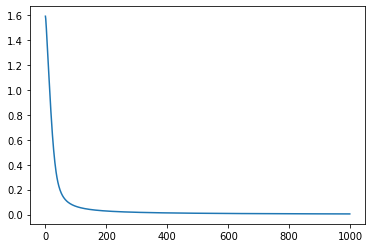

In [ ]:
train(model, 1000, criterion, optimizer, identity)